In [1]:
# 모듈 임포트 및 버전 확인
import os
import pathlib
import time
import datetime
import cv2


from matplotlib import pyplot as plt
from IPython import display



from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

from tensorflow import data
from tensorflow.keras import layers, Input, Model, losses, optimizers

import numpy as np
import tensorflow as tf
print(np.__version__)
print(tf.__version__)

1.21.4
2.6.0


In [2]:
# 프로젝트 경로 확인
os.getcwd()

'/aiffel/aiffel'

In [3]:
# Segmentation map 데이터 준비
dataset_name = "cityscapes"

_URL = f'http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/{dataset_name}.tar.gz'

# URL에서 파일 정보 가져와서 $HOME/.keras/datasets/target_file.zip 위치에 cache로 저장
path_to_zip = tf.keras.utils.get_file(
    fname=f"{dataset_name}.tar.gz",
    origin=_URL,
    extract=True)

path_to_zip  = pathlib.Path(path_to_zip)

PATH = path_to_zip.parent/dataset_name

103456768/103441232 [==============================] - 23s 0us/step


In [4]:
# cached dir 정보 확인
list(PATH.parent.iterdir())

[PosixPath('/aiffel/.keras/datasets/cityscapes'),
 PosixPath('/aiffel/.keras/datasets/cityscapes.tar.gz')]

In [5]:
# tar 압축 풀기 위해 모듈 추가 및 압축풀기(extractall())
import tarfile

target_tar_path = '/aiffel/.keras/datasets/cityscapes.tar.gz'

with tarfile.open(target_tar_path, 'r') as f:
    f.extractall()
    # dataset 위치
    # `/aiffel/aiffel/cityscapes/train/*.jpg`
    # `/aiffel/aiffel/cityscapes/val/*.jpg`

In [6]:
# 훈련 데이터 개수 확인
data_path = os.getenv('HOME')+'/aiffel/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 2975


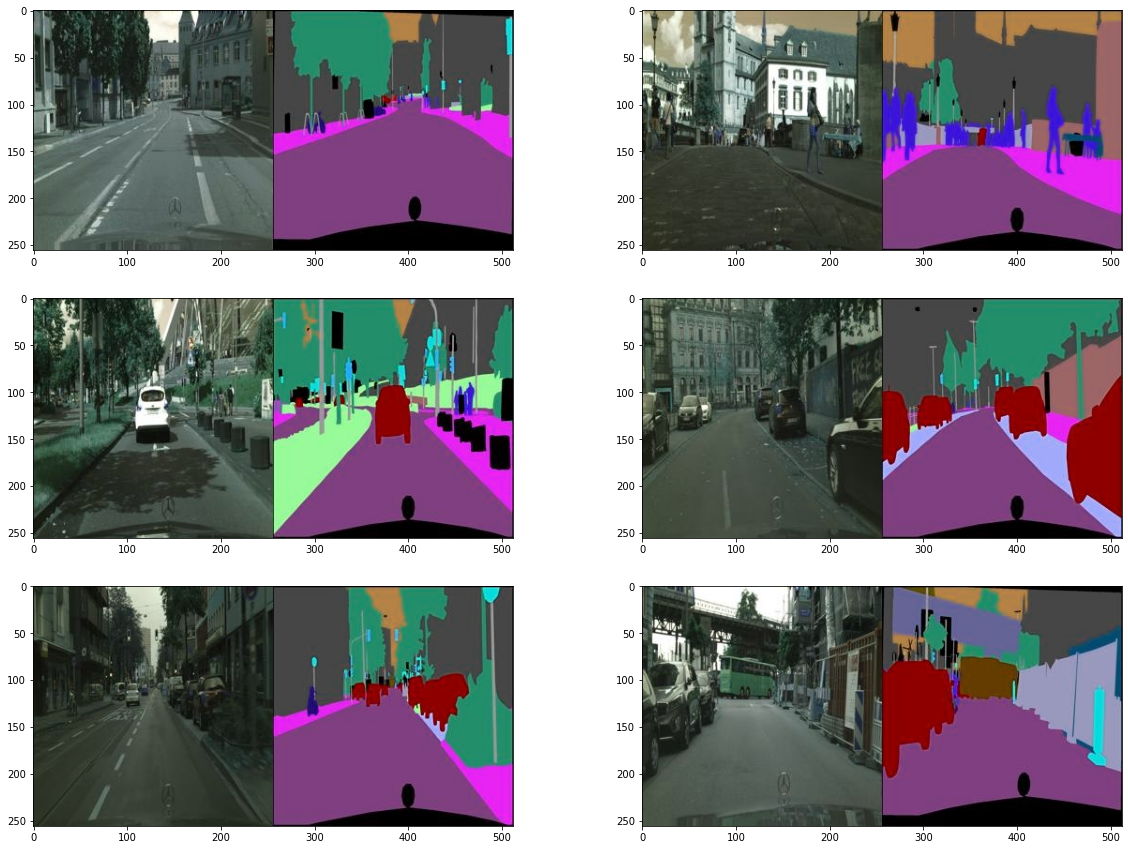

In [7]:
# 훈련 데이터 이미지 중 6개 확인

plt.figure(figsize=(20,15))
for i in range(1,7):
    # 2975 : 위에서 확인한 'number of train example'
    f = data_path + os.listdir(data_path)[np.random.randint(2975)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [8]:
# 데이터셋 하나의 크기 확인; 데이터셋은 이미지 파일
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


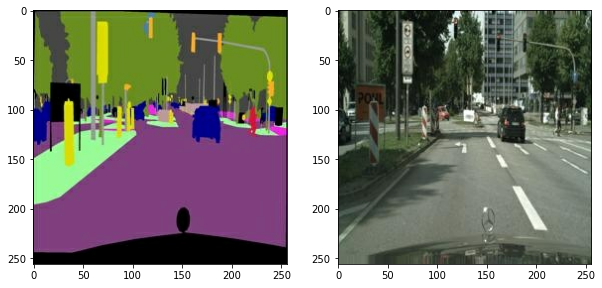

In [9]:
# 이미지 전처리를 위한 함수 선언
# input_image, real_image를 데이터셋(f)에서 획득
## denormalize() 함수 사용하여 나온 결과 확인

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    real_image = img[:, :w, :] 
    real_image = tf.cast(real_image, tf.float32)
    input_image = img[:, w:, :] 
    input_image = tf.cast(input_image, tf.float32)
    return normalize(input_image), normalize(real_image)

f = data_path + os.listdir(data_path)[1]
input_image, real_image = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(input_image))
plt.subplot(1,2,2); plt.imshow(denormalize(real_image))

In [ ]:
# Augmentation 적용
@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    # 이미지 합치기; 3채널의 이미지 두 개를 6채널의 이미지 하나로 합침
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)
    # 50% 미만의 확률로 (if 부분) Reflection padding 적용
    # 반대의 경우엔 Constant padding 적용
    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]  